In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/Datasets/NLP/facebook_comment_2k7.csv"

# Read data from csv file

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv(path)
df

,Unnamed: 0,id,text,label
0,0,3113b477-4ea3-4c3f-82d7-6ae6b8c12a3b,Noi cho biet k rãnh viet voi loai ng nhu chị c...,['harassment']
1,1,de5cf256-3879-413d-9e33-2c3be7e2e0c1,-Giải ngân cực nhanh\n-mức vay lên đến 15tr\n👉...,['dangerous_content']
2,2,975a369c-acc2-487c-84dd-64a4764203cf,Thủ tục đơn giản đăng ký khoản vay giải ngân l...,['dangerous_content']
3,3,45aa9b39-c58a-4c91-941a-fe6373d009f5,săn mãi con đen v5 cả tối k đc an ủi đc con be...,['normal']
4,4,99f6d7e6-b1c0-4849-9430-c60137737ead,zalo 0375841653 ae nào mua kết bạn zalo đặt hà...,['dangerous_content']
...,...,...,...,...
2695,2695,bf1a247d-3b42-44c1-928b-2c9c94ffccbb,chuong trinh nay co ap dung cho mua dam ngu ko ad,['normal']
2696,2696,c4366e03-d2bb-4cc4-9e89-e4abec48e6bf,Nguyễn Hoa kkk thoii thì chấp nhận làm nữ phản...,['normal']
2697,2697,aa8721e2-baec-4077-b4fc-b426c518026e,"Đổng khiết.một cô gái tài hoa,thuần khiê...",['normal']
2698,2698,9ea40a63-dedd-40ec-a7e4-5a951471be61,Chào anh/chị! Cảm ơn anh/chị đã quan tâm tới d...,['normal']


In [ ]:
df['label'].unique()

array(["['harassment']", "['dangerous_content']", "['normal']",
       "['hate_speech']", "['sexaully_explixit']",
       "['harassment', 'hate_speech']",
       "['sexaully_explixit', 'hate_speech']",
       "['hate_speech', 'harassment']",
       "['hate_speech', 'sexaully_explixit']",
       "['sexaully_explixit', 'dangerous_content']",
       "['harassment', 'sexaully_explixit']",
       "['hate_speech', 'dangerous_content']"], dtype=object)

# Pre-processing data

In [ ]:
df['label'] = df['label'].apply(lambda x: x.strip("[]").split(",")[0])

In [ ]:
import re
def clean_text(text):
    text = re.sub('<.*?>', '', text).strip()
    text = re.sub('(\s)+', r'\1', text)
    return text

## Tokenize text

In [ ]:
!pip install underthesea
from underthesea import text_normalize, word_tokenize
X = [word_tokenize(text_normalize(clean_text(sentence)).lower()) for sentence in df['text']]
y = df['label']

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 27.6 MB/s eta 0:00:00


## Convert text to matrix with mode "count"

In [ ]:
from keras.preprocessing.text import Tokenizer
t = Tokenizer()
t.fit_on_texts(X)

X = t.texts_to_matrix(X, mode='count')
X = np.array(X)

## Handle imbalanced data with OverSampler

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42,
                                                    test_size=0.2)
print(X_train.shape)
print(y_train.shape)

(2160, 9927)
(2160,)


In [ ]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

## Training model

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

models = {
    "Multinomial NB" : MultinomialNB(),
    "Logistic Regression" : LogisticRegression(penalty="l2", tol=0.001, C=0.5, max_iter=100),
    "RandomForest" : RandomForestClassifier(),
    "KNN" : KNeighborsClassifier(n_neighbors=15)
}

In [ ]:
from sklearn.metrics import classification_report

accs = {model_name : [] for model_name in models}
for model_name, model in models.items():
    model.fit(X_resampled, y_resampled)
    y_pred = model.predict(X_test)
    print("Model:", model_name)
    print(classification_report(y_test, y_pred))
    report = classification_report(y_test, y_pred, output_dict=True)
    accs[model_name].append(report['accuracy'])

Model: Multinomial NB
                     precision    recall  f1-score   support

'dangerous_content'       0.87      0.90      0.88        51
       'harassment'       0.18      0.41      0.25        29
      'hate_speech'       0.50      0.62      0.55        91
           'normal'       0.93      0.75      0.83       328
'sexaully_explixit'       0.49      0.51      0.50        41

           accuracy                           0.71       540
          macro avg       0.59      0.64      0.60       540
       weighted avg       0.78      0.71      0.73       540



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model: Logistic Regression
                     precision    recall  f1-score   support

'dangerous_content'       0.94      0.88      0.91        51
       'harassment'       0.29      0.34      0.31        29
      'hate_speech'       0.71      0.60      0.65        91
           'normal'       0.88      0.92      0.90       328
'sexaully_explixit'       0.74      0.61      0.67        41

           accuracy                           0.81       540
          macro avg       0.71      0.67      0.69       540
       weighted avg       0.81      0.81      0.81       540

Model: RandomForest
                     precision    recall  f1-score   support

'dangerous_content'       0.96      0.88      0.92        51
       'harassment'       0.38      0.10      0.16        29
      'hate_speech'       0.79      0.59      0.68        91
           'normal'       0.81      0.99      0.89       328
'sexaully_explixit'       0.88      0.34      0.49        41

           accuracy              

In [ ]:
X = [word_tokenize(text_normalize(clean_text(sentence)).lower()) for sentence in df['text']]
X = t.texts_to_matrix(X, mode='tfidf')
X = np.array(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42,
                                                    test_size=0.2)

X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

for model_name, model in models.items():
    model.fit(X_resampled, y_resampled)
    y_pred = model.predict(X_test)
    print("Model:", model_name)
    print(classification_report(y_test, y_pred))
    report = classification_report(y_test, y_pred, output_dict=True)
    accs[model_name].append(report['accuracy'])

Model: Multinomial NB
                     precision    recall  f1-score   support

'dangerous_content'       0.94      0.88      0.91        51
       'harassment'       0.24      0.38      0.30        29
      'hate_speech'       0.55      0.64      0.59        91
           'normal'       0.90      0.84      0.87       328
'sexaully_explixit'       0.50      0.44      0.47        41

           accuracy                           0.75       540
          macro avg       0.63      0.64      0.63       540
       weighted avg       0.78      0.75      0.76       540



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model: Logistic Regression
                     precision    recall  f1-score   support

'dangerous_content'       0.96      0.88      0.92        51
       'harassment'       0.32      0.28      0.30        29
      'hate_speech'       0.71      0.64      0.67        91
           'normal'       0.88      0.96      0.92       328
'sexaully_explixit'       0.81      0.51      0.63        41

           accuracy                           0.83       540
          macro avg       0.73      0.65      0.69       540
       weighted avg       0.82      0.83      0.82       540

Model: RandomForest
                     precision    recall  f1-score   support

'dangerous_content'       0.98      0.90      0.94        51
       'harassment'       0.45      0.17      0.25        29
      'hate_speech'       0.77      0.59      0.67        91
           'normal'       0.82      0.99      0.90       328
'sexaully_explixit'       0.88      0.37      0.52        41

           accuracy              

In [ ]:
X = [word_tokenize(text_normalize(clean_text(sentence)).lower()) for sentence in df['text']]
X = t.texts_to_matrix(X, mode='binary')
X = np.array(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=43,
                                                    test_size=0.2)

X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

for model_name, model in models.items():
    model.fit(X_resampled, y_resampled)
    y_pred = model.predict(X_test)
    print("Model:", model_name)
    print(classification_report(y_test, y_pred))
    report = classification_report(y_test, y_pred, output_dict=True)
    accs[model_name].append(report['accuracy'])

Model: Multinomial NB
                     precision    recall  f1-score   support

'dangerous_content'       0.86      0.79      0.83        48
       'harassment'       0.24      0.40      0.30        40
      'hate_speech'       0.48      0.67      0.56        93
           'normal'       0.92      0.73      0.82       309
'sexaully_explixit'       0.57      0.58      0.57        50

           accuracy                           0.69       540
          macro avg       0.61      0.63      0.61       540
       weighted avg       0.75      0.69      0.71       540

Model: Logistic Regression
                     precision    recall  f1-score   support

'dangerous_content'       0.93      0.81      0.87        48
       'harassment'       0.42      0.40      0.41        40
      'hate_speech'       0.72      0.60      0.65        93
           'normal'       0.86      0.94      0.90       309
'sexaully_explixit'       0.69      0.58      0.63        50

           accuracy            

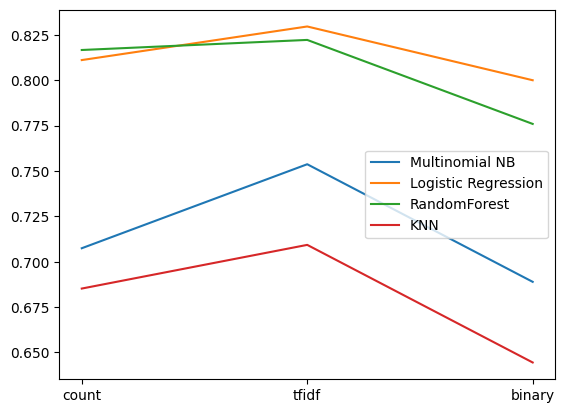

In [ ]:
import matplotlib.pyplot as plt

modes = ["count", "tfidf", "binary"]

for model, acc in accs.items():
    plt.plot(modes, acc, label=model)
plt.legend()
plt.show()

In [ ]:
# question = input()
# X_input = t.texts_to_matrix([question], mode='count')
# print(X_input)
# y_output = model.predict(X_input)
# print(y_output)

# Using Fasttext to Embedding word

In [ ]:
from gensim.models import FastText
from gensim.models import Word2Vec

train_data = [word_tokenize(text_normalize(clean_text(sentence)).lower()) for sentence in df['text']]

model = FastText(train_data,
                 vector_size=1024,
                 window=5,
                 min_count=1,
                 workers=4,
                 epochs=25,
                 seed=42,
                 sg=1)

In [ ]:
ftext = model.wv
len(ftext.index_to_key)

9926

In [ ]:
X = [ftext[text_normalize(clean_text(sentence)).lower()] for sentence in df['text']]
X = np.array(X)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42,
                                                    test_size=0.25)

X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

model = RandomForestClassifier()
model.fit(X_resampled, y_resampled)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

                     precision    recall  f1-score   support

'dangerous_content'       0.95      0.87      0.91        67
       'harassment'       0.25      0.10      0.15        39
      'hate_speech'       0.58      0.57      0.57       113
           'normal'       0.82      0.95      0.88       404
'sexaully_explixit'       0.89      0.31      0.46        52

           accuracy                           0.78       675
          macro avg       0.70      0.56      0.59       675
       weighted avg       0.76      0.78      0.76       675



# Using Neural Network

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam

In [ ]:
from sklearn.preprocessing import LabelEncoder

X = [word_tokenize(text_normalize(clean_text(sentence)).lower()) for sentence in df['text']]
X = t.texts_to_matrix(X, mode='tfidf')
X = np.array(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42,
                                                    test_size=0.25)

X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

le = LabelEncoder()

y_resampled = le.fit_transform(y_resampled)

from tensorflow.keras.utils import to_categorical
y_resampled = to_categorical(y_resampled)

In [ ]:
model = Sequential()
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(5, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
hist = model.fit(X_resampled, y_resampled, epochs=15, batch_size=64, validation_split=0.2, verbose=1)

Epoch 1/15
75/75 [==============================] - 3s 22ms/step - loss: 0.8601 - accuracy: 0.7361 - val_loss: 1.9502 - val_accuracy: 0.2107
Epoch 2/15
75/75 [==============================] - 1s 12ms/step - loss: 0.1861 - accuracy: 0.9601 - val_loss: 0.3844 - val_accuracy: 0.9152
Epoch 3/15
75/75 [==============================] - 1s 10ms/step - loss: 0.0603 - accuracy: 0.9861 - val_loss: 0.1002 - val_accuracy: 0.9849
Epoch 4/15
75/75 [==============================] - 1s 9ms/step - loss: 0.0351 - accuracy: 0.9908 - val_loss: 0.0821 - val_accuracy: 0.9874
Epoch 5/15
75/75 [==============================] - 1s 11ms/step - loss: 0.0272 - accuracy: 0.9908 - val_loss: 0.0618 - val_accuracy: 0.9882
Epoch 6/15
75/75 [==============================] - 1s 11ms/step - loss: 0.0269 - accuracy: 0.9901 - val_loss: 0.0781 - val_accuracy: 0.9882
Epoch 7/15
75/75 [==============================] - 1s 10ms/step - loss: 0.0233 - accuracy: 0.9912 - val_loss: 0.0273 - val_accuracy: 0.9882
Epoch 8/15
75/

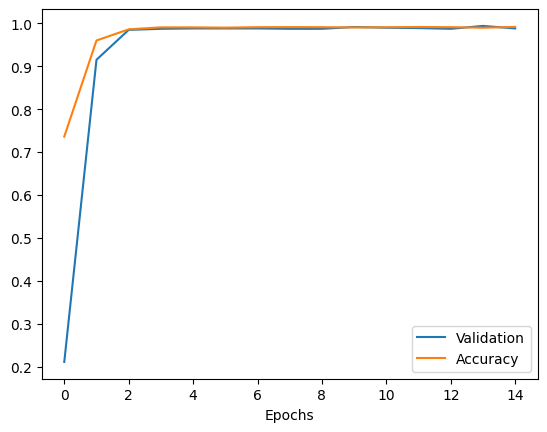

In [ ]:
plt.plot(hist.history['val_accuracy'], label="Validation")
plt.plot(hist.history['accuracy'], label="Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()

In [ ]:
y_pred = model.predict(X_test)
y_pred = y_pred.argmax(axis=1)

from sklearn.metrics import classification_report

print(classification_report(le.transform(y_test), y_pred))

22/22 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.97      0.91      0.94        67
           1       0.42      0.33      0.37        39
           2       0.64      0.62      0.63       113
           3       0.86      0.94      0.89       404
           4       0.71      0.42      0.53        52

    accuracy                           0.81       675
   macro avg       0.72      0.64      0.67       675
weighted avg       0.80      0.81      0.80       675

